In [1]:
import utils
import network
from torch.utils import data
from datasets import VOCSegmentation, Cityscapes

model_name     = 'deeplabv3plus_mobilenet'
num_classes    = 21
output_stride  = 16
separable_conv = False

In [2]:
# Set up model (all models are 'constructed at network.modeling)
#model = network.modeling.__dict__[model_name](num_classes=num_classes, output_stride=output_stride)
#if separable_conv and 'plus' in model_name:
#    network.convert_to_separable_conv(model.classifier)
#utils.set_bn_momentum(model.backbone, momentum=0.01)
# Set up model (all models are 'constructed at network.modeling)
model = network.modeling.__dict__[model_name](num_classes=num_classes, output_stride=output_stride)
if separable_conv and 'plus' in model_name:
    network.convert_to_separable_conv(model.classifier)
utils.set_bn_momentum(model.backbone, momentum=0.01)

In [3]:
import torch

ckpt = torch.load('checkpoints/best_deeplabv3plus_mobilenet_voc_os16.pth',map_location=torch.device('cpu'))['model_state']
model.load_state_dict(ckpt)

<All keys matched successfully>

In [4]:
from utils import ext_transforms as et
def _get_dataset(dataset='voc',crop_size=256,crop_val=False,data_root='/home/irfan/Desktop/Data/VOCtrainval_11-May-2012'):
    """ Dataset And Augmentation
    """
    if dataset == 'voc':
        train_transform = et.ExtCompose([
            # et.ExtResize(size=opts.crop_size),
            et.ExtRandomScale((0.5, 2.0)),
            et.ExtRandomCrop(size=(crop_size, crop_size), pad_if_needed=True),
            et.ExtRandomHorizontalFlip(),
            et.ExtToTensor(),
            et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
        ])
        if crop_val:
            val_transform = et.ExtCompose([
                et.ExtResize(crop_size),
                et.ExtCenterCrop(crop_size),
                et.ExtToTensor(),
                et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
            ])
        else:
            val_transform = et.ExtCompose([
                et.ExtToTensor(),
                et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
            ])
        train_dst = VOCSegmentation(root=data_root, year='2012',
                                    image_set='train', download=False, transform=train_transform)
        val_dst = VOCSegmentation(root=data_root, year='2012',
                                  image_set='val', download=False, transform=val_transform)

    if dataset == 'cityscapes':
        train_transform = et.ExtCompose([
            # et.ExtResize( 512 ),
            et.ExtRandomCrop(size=(crop_size, crop_size)),
            et.ExtColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            et.ExtRandomHorizontalFlip(),
            et.ExtToTensor(),
            et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
        ])

        val_transform = et.ExtCompose([
            # et.ExtResize( 512 ),
            et.ExtToTensor(),
            et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
        ])

        train_dst = Cityscapes(root=data_root,
                               split='train', transform=train_transform)
        val_dst = Cityscapes(root= data_root,
                             split='val', transform=val_transform)
    return train_dst, val_dst


In [5]:
class Params:
    def __init__(self):
        # Datset Options
        self.data_root ='/home/irfan/Desktop/Data/VOCtrainval_11-May-2012'#VOCdevkit/VOC2012/'                  
        self.dataset ='voc'
        self.num_classes =None

        # Deeplab Options
        available_models = sorted(name for name in network.modeling.__dict__ if name.islower() and \
                                  not (name.startswith("__") or name.startswith('_')) and callable(
                                  network.modeling.__dict__[name])
                                  )
        self.model = 'deeplabv3plus_mobilenet'
        self.separable_conv = False
        self.output_stride  = 16
        # Train Options
        self.test_only      = False
        self.save_val_results = False
        self.total_itrs     = 30e3
        self.lr             = 0.01
        self.lr_policy      = 'poly'

        self.step_size      = 10000
        self.crop_val       = True
        self.batch_size     = 8
        self.val_batch_size = 8
        self.crop_size      = 256
        self.ckpt           = None
        self.continue_training = False

        self.loss_type      = 'cross_entropy'
        self.gpu_id         = '0'
        self.weight_decay   = 1e-4
        self.random_seed    = 1
        self.print_interval = 10
        self.val_interval   = 100
        self.download       = False
        # PASCAL VOC Options
        self.year           ='2012'

        # Visdom options
        self.enable_vis     = False              
        self.vis_port       ='13570'
        self.vis_env        ='main'
        self.vis_num_samples =8
        
def get_dataset(opts):
    """ Dataset And Augmentation
    """
    if opts.dataset == 'voc':
        train_transform = et.ExtCompose([
            # et.ExtResize(size=opts.crop_size),
            et.ExtRandomScale((0.5, 2.0)),
            et.ExtRandomCrop(size=(opts.crop_size, opts.crop_size), pad_if_needed=True),
            et.ExtRandomHorizontalFlip(),
            et.ExtToTensor(),
            et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
        ])
        if opts.crop_val:
            val_transform = et.ExtCompose([
                et.ExtResize(opts.crop_size),
                et.ExtCenterCrop(opts.crop_size),
                et.ExtToTensor(),
                et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
            ])
        else:
            val_transform = et.ExtCompose([
                et.ExtToTensor(),
                et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
            ])
        train_dst = VOCSegmentation(root=opts.data_root, year=opts.year,
                                    image_set='train', download=opts.download, transform=train_transform)
        val_dst = VOCSegmentation(root=opts.data_root, year=opts.year,
                                  image_set='val', download=False, transform=val_transform)

    if opts.dataset == 'cityscapes':
        train_transform = et.ExtCompose([
            # et.ExtResize( 512 ),
            et.ExtRandomCrop(size=(opts.crop_size, opts.crop_size)),
            et.ExtColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            et.ExtRandomHorizontalFlip(),
            et.ExtToTensor(),
            et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
        ])

        val_transform = et.ExtCompose([
            # et.ExtResize( 512 ),
            et.ExtToTensor(),
            et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
        ])

        train_dst = Cityscapes(root=opts.data_root,
                               split='train', transform=train_transform)
        val_dst = Cityscapes(root=opts.data_root,
                             split='val', transform=val_transform)
    return train_dst, val_dst
opts    = Params()
train_dst, val_dst = get_dataset(opts) 

/home/irfan/Desktop/Data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012
/home/irfan/Desktop/Data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012


In [6]:
#train_dst, val_dst = get_dataset()
#train_loader = data.DataLoader(
#    train_dst, batch_size=opts.batch_size, shuffle=True, num_workers=2,
#    drop_last=True)  # drop_last=True to ignore single-image batches.

In [21]:
#aa=val_dst.__getitem__(0)
#img,lbl    = val_dst.__getitem__(0)
val_loader = data.DataLoader(val_dst, batch_size=8, shuffle=False, num_workers=2)
for i,(imgs,lbls) in enumerate(val_loader):
    break

/home/irfan/Desktop/Code/Linux-IO/python_38/lib/python3.8/site-packages/torchvision/transforms/functional.py:417: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/home/irfan/Desktop/Code/Linux-IO/python_38/lib/python3.8/site-packages/torchvision/transforms/functional.py:417: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [23]:
preds=model(imgs)

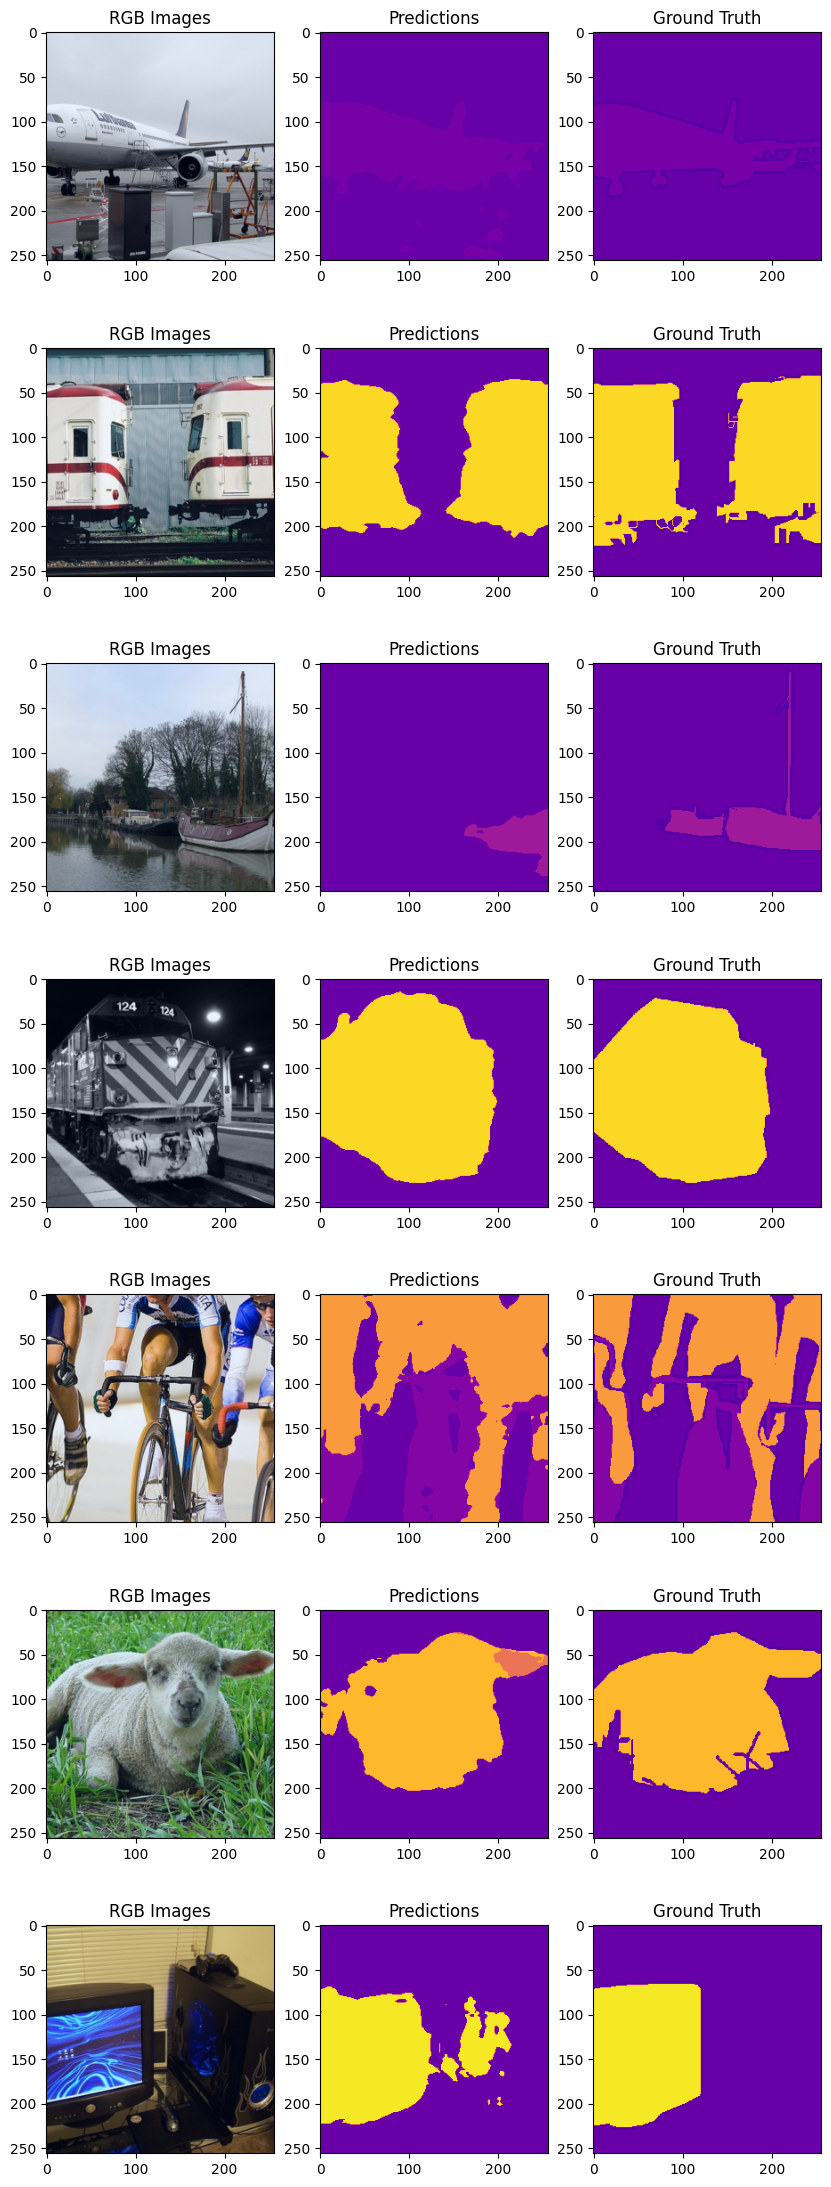

In [47]:
from matplotlib import pyplot as plt
def denorm(img):
    im = torch.permute(img.detach().cpu(),(1,2,0))
    im = im - im.min()
    im = im / im.max()
    return im.numpy()

fig,axes= plt.subplots(nrows=7,ncols=3,figsize=(10,28))
for i,[_img,_pred,_lbl] in enumerate(zip(imgs,preds,lbls)):
    axes[i,0].imshow(denorm(_img)); axes[i,0].set_title('RGB Images')
    axes[i,1].imshow(_pred.argmax(axis=0).detach().cpu().numpy()+5,vmin=0,vmax=21+5, cmap='plasma'); axes[i,1].set_title('Predictions')
    axes[i,2].imshow(_lbl.detach().cpu().numpy()+5,vmin=0,vmax=21+5,cmap='plasma'); axes[i,2].set_title('Ground Truth')
    if i==6: break

In [48]:
plt.tight_layout()
fig.savefig('result.png')

<Figure size 640x480 with 0 Axes>

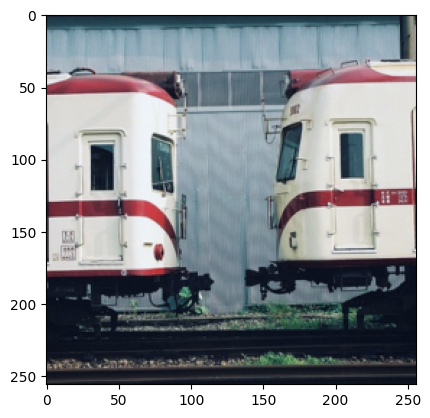

In [14]:

plt.imshow(im)